### Exploring the annotated data.

In [1]:
from datasets import load_dataset, disable_caching
import pandas as pd

# can infer the generic loader script this easily
disable_caching()
# cache location [click](%userprofile%/.cache/huggingface/datasets)
# needs force_redownload to avoid loading incorrect cached stuff
ds = load_dataset("json", data_dir="./data/annotated/", download_mode="force_redownload", cache_dir=None)
df = ds["train"].to_pandas()
# read "date" column as unix timestamp
df["date"] = pd.to_datetime(df["date"].astype(int), unit="s")
ds

Resolving data files:   0%|          | 0/95 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/19622 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'published', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'thumbnail', 'access', 'license', 'functions', 'test'],
        num_rows: 19622
    })
})

In [2]:
# #344 seems to crash/hang up and ruin the kernel. (works isolated?)
# run_shader(ds["train"][344])

In [3]:
# list of permissive licenses like: https://huggingface.co/datasets/bigcode/the-stack-v2/blob/main/license_stats.csv (gated?)
# maybe this instead: https://huggingface.co/datasets/bigcode/the-stack/blob/main/licenses.json
# seems to be the one they actually use: https://huggingface.co/datasets/bigcode-data/license_list/resolve/main/permissive_licenses.txt 

import requests
permissive_list = requests.get("https://huggingface.co/datasets/bigcode-data/license_list/resolve/main/permissive_licenses.txt").content.decode("utf-8").split()
permissive_list = [l.lower() for l in permissive_list]

print(len(permissive_list))


824


In [4]:

print(ds["train"].unique("license"))
# filter permissive licenses
permissive_ds = ds["train"].filter(lambda x: x["license"].lower() in permissive_list) #what about those AND and OR classifications?
permissive_ds

['CC-BY-NC-SA-3.0', 'cc-by-nc-sa-3.0', 'bsd-new', 'mit', 'cc-by-4.0', 'proprietary-license', 'cc-by-nc-nd-3.0', 'bsd-simplified', 'cc0-1.0', 'unknown-license-reference', 'public-domain', 'apache-2.0', 'cc-by-nc-sa-4.0', 'agpl-3.0', 'cc-by-sa-3.0', 'cc-by-3.0', 'cc-by-sa-2.5', 'cc-by-sa-4.0', 'cc-by-sa-4.0 WITH generic-exception', 'cc-by-3.0 AND mit', 'cc-by-nc-sa-2.0', 'cc-by-nc-sa-3.0 AND proprietary-license', 'wtfpl-2.0', 'gpl-3.0', 'cc-by-4.0 OR cc-by-3.0', 'beerware', 'gpl-3.0-plus OR cc-by-sa-3.0', 'unlicense', 'cc-by-nc-nd-4.0', 'warranty-disclaimer', 'x11', 'gpl-3.0-plus', 'cc-by-nc-4.0', 'cc-by-2.5', 'cc0-1.0 OR openssl-ssleay OR apache-2.0', 'gpl-2.0', 'gpl-2.0-plus', 'cc-by-nc-3.0', 'gpl-1.0-plus', 'artistic-2.0', 'cc-sampling-plus-1.0']


Filter:   0%|          | 0/19622 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'published', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'thumbnail', 'access', 'license', 'functions', 'test'],
    num_rows: 660
})

In [5]:
# seems to never contain any common pass? or my preprocessing is wrong.
print(df["common_code"].unique()) 

# see how many shaders contain buffer passes (seemingly none?)
ds["train"].filter(lambda x: x["buffer_a_code"] + x["buffer_b_code"] + x["buffer_c_code"] + x["buffer_d_code"] != "")

['']


Filter:   0%|          | 0/19622 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'published', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'thumbnail', 'access', 'license', 'functions', 'test'],
    num_rows: 0
})

<Axes: title={'center': 'license'}, xlabel='date'>

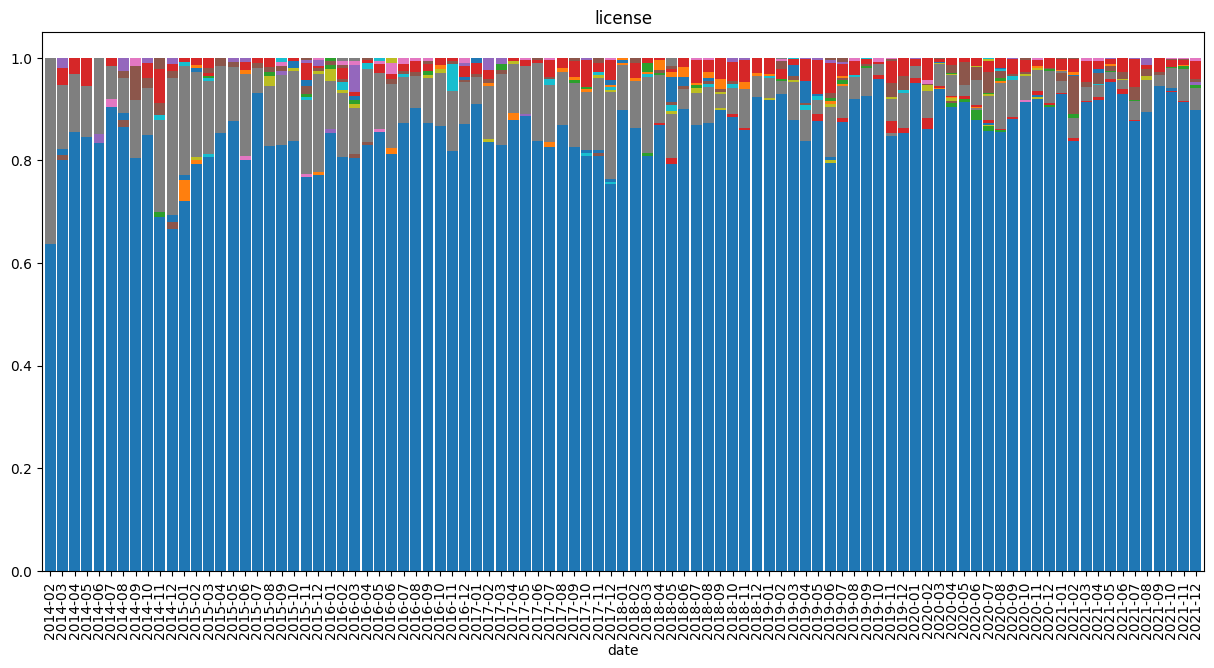

In [6]:
def plot_per_month(column, stretched=False, **kwargs):
    feature_df = df["date"].groupby([df["date"].dt.to_period("M"), df[column]]).count().unstack()
    if stretched:
        feature_df = feature_df.div(feature_df.sum(axis=1), axis=0)
    return feature_df.plot(kind="bar", stacked=True, figsize=(15,7), title=column, width=.9, **kwargs)
    
plot_per_month("license", True, legend=False)

<Axes: title={'center': 'published'}, xlabel='date'>

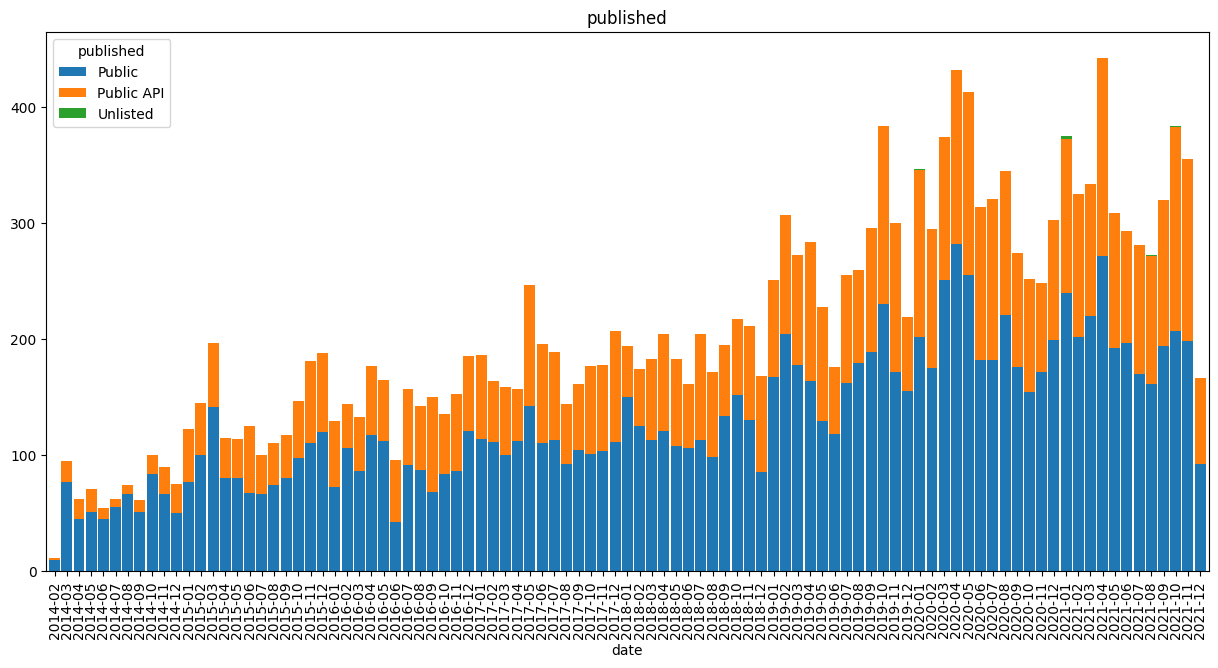

In [7]:
plot_per_month("published", False)

<Axes: title={'center': 'test'}, xlabel='date'>

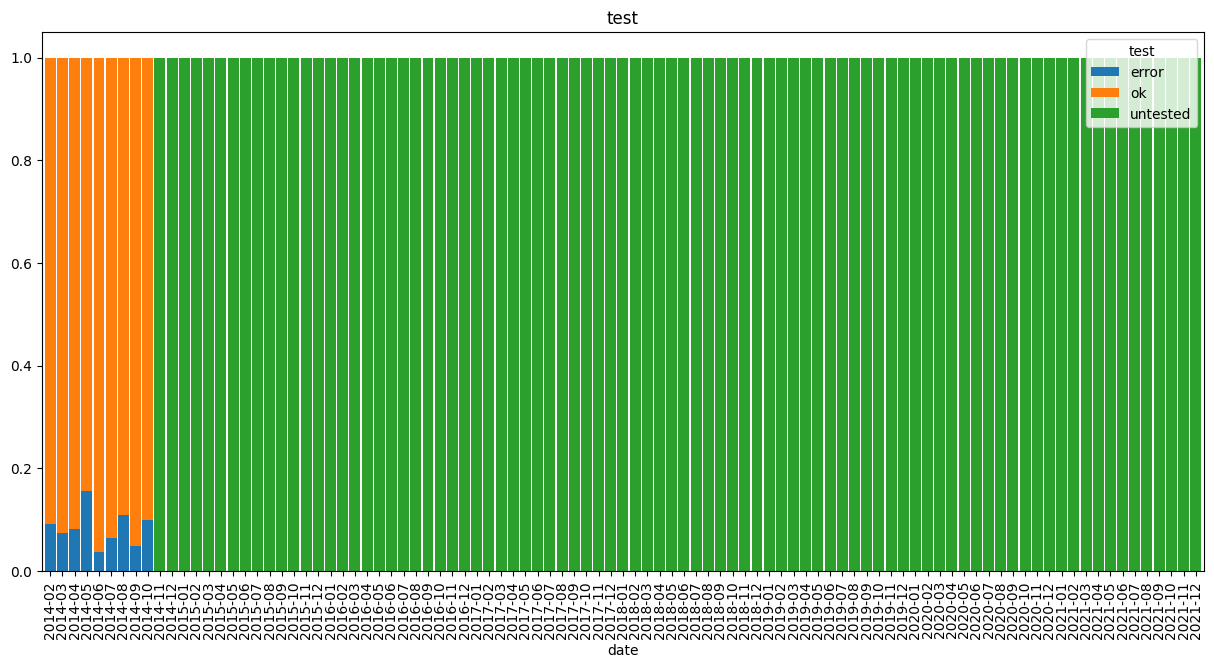

In [8]:
# currently in development, another filtering step.
plot_per_month("test", stretched=True, legend=True)

In [9]:
df["num_functions"] = df["functions"].apply(len)
df["num_functions"].describe()

count    19622.000000
mean         8.108450
std         10.439794
min          0.000000
25%          2.000000
50%          5.000000
75%         10.000000
max        358.000000
Name: num_functions, dtype: float64

In [10]:
# these cases might be parsing failures? seem to always use macros inside functions or something.
# some use no functions but Main(){...} which seems to work in glsl but not viable for our dataset
from annotate import PARSER
print(PARSER.parse(bytes(df["image_code"][5090],encoding="utf-8")).root_node.has_error)
df.loc[df["num_functions"] == 0]

False


,id,name,author,description,tags,likes,viewed,published,date,time_retrieved,...,buffer_d_code,buffer_d_inputs,cube_a_code,cube_a_inputs,thumbnail,access,license,functions,test,num_functions
62,Md23DV,GLSL 2D Tutorials,vug,28 tutorials on writing pixel shaders at Shade...,[tutorial],581,48910,Public,2014-03-08 20:58:49,2021-10-01,...,,[],,[],https://www.shadertoy.com/media/shaders/Md23DV...,shaders20k,CC-BY-NC-SA-3.0,[],ok,0
4809,MsSyzW,2D Worley and Cell Noise,TinyTexel,left: 1 - worley\nmiddle: f2^2 - f1^2\nright: ...,"[voronoi, noise, worley]",12,348,Public,2017-04-01 18:38:57,2021-10-01,...,,[],,[],https://www.shadertoy.com/media/shaders/MsSyzW...,shaders20k,CC-BY-NC-SA-3.0,[],untested,0
5090,XtySDz,Shadertoy 튜토리얼 한글번역,ho4040,Korean version of https://www.shadertoy.com/vi...,"[tutorial, korean]",7,1040,Public API,2017-05-26 03:06:13,2021-10-01,...,,[],,[],https://www.shadertoy.com/media/shaders/XtySDz...,shaders20k,CC-BY-NC-SA-3.0,[],untested,0
5626,4lfczB,Sphere over lake,Nowado,Any description,[sphere],6,444,Public API,2017-09-14 10:06:26,2021-10-01,...,,[],,[],https://www.shadertoy.com/media/shaders/4lfczB...,shaders20k,CC-BY-NC-SA-3.0,[],untested,0
5743,XlfcD4,dizzy,sgoal,dizzy,[dizzy],0,66,Public,2017-09-07 04:35:57,2021-10-01,...,,[],,[],https://www.shadertoy.com/media/shaders/XlfcD4...,shaders20k,CC-BY-NC-SA-3.0,[],untested,0
5746,XlfyRj,Dancing Star,SunLuke,dance,[huehe],2,116,Public,2017-09-14 12:56:59,2021-10-01,...,,[],,[],https://www.shadertoy.com/media/shaders/XlfyRj...,shaders20k,CC-BY-NC-SA-3.0,[],untested,0
8489,llGfW3,rolling triangle tiling (310 ch),FabriceNeyret2,"Funnily, drawing all triangles makes [url]http...","[2d, geometry, gif, short, reproductions]",9,493,Public API,2018-12-07 21:29:36,2021-10-01,...,,[],,[],https://www.shadertoy.com/media/shaders/llGfW3...,shaders20k,CC-BY-NC-SA-3.0,[],untested,0
9948,wtX3zB,Almost My First Shader,dr2,See the source...,"[raymarch, landscape, flight, car]",10,602,Public API,2019-05-01 09:54:07,2021-10-01,...,,[],,[],https://www.shadertoy.com/media/shaders/wtX3zB...,shaders20k,cc-by-nc-sa-3.0,[],untested,0
11273,WsGGWy,Move in circle ( tutorial ),Kiltun,A simple shader of a circle moving on a ring.\...,"[tutorial, circle, ring, move, moveincircle]",1,172,Public,2019-10-11 16:30:36,2021-10-01,...,,[],,[],https://www.shadertoy.com/media/shaders/WsGGWy...,shaders20k,CC-BY-NC-SA-3.0,[],untested,0
15144,WdyyDR,Great Ideas in Graphics Demo,sjobalia,Demo for Great Ideas in Graphics,[demo],1,98,Public,2020-10-12 22:55:41,2021-10-01,...,,[],,[],https://www.shadertoy.com/media/shaders/WdyyDR...,shaders20k,CC-BY-NC-SA-3.0,[],untested,0


In [11]:
# TODO: refactor into a generator because I dislike the current shape. but figure out how batching and threadding works then?
# part of the filter.py or prepare.py script that will be done soon.
def split_functions(batch):
    # per function fields
    comments, headers, docstrings, bodies = [],[],[],[]
    # per document fields
    full_code, funcs, ids = [],[],[]
    for code, func_bytes, shader_id in zip(batch["image_code"], batch["functions"], batch["id"]):
        row_code = bytes(code,encoding="utf-8")
        for start_comment, start_header, end_header, end_docstring, end_function in func_bytes:
            comments.append(row_code[start_comment:start_header].decode(encoding="utf-8")),
            headers.append(row_code[start_header:end_header].decode(encoding="utf-8")),
            docstrings.append(row_code[end_header:end_docstring].decode(encoding="utf-8")),
            bodies.append(row_code[end_docstring:end_function].decode(encoding="utf-8")),
            full_code.append(row_code.decode(encoding="utf-8")),
            funcs.append((start_comment, start_header, end_header, end_docstring, end_function))
            ids.append(shader_id)
    return {
            "comment": comments,
            "header": headers,
            "docstring": docstrings,
            "body": bodies,
            "full_code": full_code,
            "func_bytes": funcs,
            "id": ids,
            }


# func_ds = ds.map(split_functions, batched=True, remove_columns=ds["train"].column_names) # full dataset to functions
func_ds = permissive_ds.map(split_functions, batched=True, remove_columns=permissive_ds.column_names) # only permissive shaders (the whole 20k set is single pass without common...)
if "train" in func_ds:
    func_ds = func_ds["train"]
func_ds

Map:   0%|          | 0/660 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'comment', 'header', 'docstring', 'body', 'full_code', 'func_bytes'],
    num_rows: 6132
})

In [12]:
func_df = func_ds.to_pandas()
func_df.head() 

,id,comment,header,docstring,body,full_code,func_bytes
0,ld23DV,// http://iquilezles.org/www/articles/boxfunct...,"vec4 iBox( in vec3 ro, in vec3 rd, in mat4 txx...",\n // convert from ray to box space,"\n\tvec3 rdd = (txx*vec4(rd,0.0)).xyz;\n\tvec3...",// The MIT License\n// Copyright © 2014 Inigo ...,"[2107, 2175, 2252, 2289, 2807]"
1,ld23DV,// http://iquilezles.org/www/articles/boxfunct...,"float sBox( in vec3 ro, in vec3 rd, in mat4 tx...",,"\n\tvec3 rdd = (txx*vec4(rd,0.0)).xyz;\n\tvec3...",// The MIT License\n// Copyright © 2014 Inigo ...,"[2810, 2878, 2943, 2943, 3273]"
2,ld23DV,//--------------------------------------------...,"mat4 rotationAxisAngle( vec3 v, float angle )\n{",,\n float s = sin( angle );\n float c = c...,// The MIT License\n// Copyright © 2014 Inigo ...,"[3276, 3369, 3416, 3416, 3820]"
3,ld23DV,,"mat4 translate( float x, float y, float z )\n{",,"\n return mat4( 1.0, 0.0, 0.0, 0.0,\n\t\t\t...",// The MIT License\n// Copyright © 2014 Inigo ...,"[3822, 3822, 3867, 3867, 3983]"
4,ld23DV,/*\nmat4 inverse( in mat4 m )\n{\n\treturn mat...,"void mainImage( out vec4 fragColor, in vec2 fr...",,\n\tvec2 p = (2.0*fragCoord-iResolution.xy) / ...,// The MIT License\n// Copyright © 2014 Inigo ...,"[3984, 4268, 4325, 4325, 7081]"


In [13]:
func_df["has_comment"] = func_df["comment"] != ""
func_df["has_docstring"] = func_df["docstring"] != ""
func_df["model_ctx"] = func_df["comment"] + func_df["header"] + func_df["comment"]
# how many functions are there, and what is the share of comments, 

xtab = pd.crosstab(func_df["has_comment"], func_df["has_docstring"], margins=True)
print(f"functions with context = {xtab.iloc[-1,-1] - xtab.iloc[0,0]}")
xtab

# for the permissive subset of shaders 21k the number goes down to like 253 for both...

functions with context = 2352


has_docstring,False,True,All
has_comment,,,
False,3780,321,4101
True,1778,253,2031
All,5558,574,6132


In [14]:
# FINDING: only about half the comments are unique.
# some frequent comment looks like a template maybe? should investigate
print(func_df["comment"].nunique())
func_df["comment"].value_counts(sort=True, ascending=False).head(10)

1314


comment
                                                                                                                                                                                                         4101
//------------------------------------------------------------------\n\n                                                                                                                                   55
// http://iquilezles.org/www/articles/normalsSDF/normalsSDF.htm\n                                                                                                                                          34
//CC0 1.0 Universal https://creativecommons.org/publicdomain/zero/1.0/\n//To the extent possible under law, Blackle Mori has waived all copyright and related or neighboring rights to this work.\n\n      24
// http://iquilezles.org/www/articles/rmshadows/rmshadows.htm\n                                                                                                         

In [15]:
# FINDING = only about a third of function-headers are unique?
# it's expect to have one mainImage function per renderpass... but they are just whitesapce variable here - maybe we skip them in general
print(func_df["header"].nunique())
func_df["header"].value_counts(sort=True, ascending=False).head(10)

2977


header
void mainImage( out vec4 fragColor, in vec2 fragCoord )\n{    492
void mainImage(out vec4 fragColor, in vec2 fragCoord) {        65
float scene(vec3 p) {                                          62
vec3 erot(vec3 p, vec3 ax, float ro) {                         57
vec3 norm(vec3 p) {                                            55
vec3 calcNormal( in vec3 pos )\n{                              45
void mainImage( out vec4 fragColor, in vec2 fragCoord ) {      34
float tanh_approx(float x) {                                   27
vec3 hsv2rgb(vec3 c) {                                         26
float pmin(float a, float b, float k) {                        25
Name: count, dtype: int64

In [16]:
# looks like some are not exact or might even use the common pass to bypass this
func_df["header"].str.startswith("void mainImage").sum()

659

In [17]:
# half the docstrings aren't unique?
# most common one is the shadertoy.com/new default for the main function
print(func_df["docstring"].nunique())
func_df["docstring"].value_counts(sort=True, ascending=False).head(10)

297


docstring
                                                                                           5558
\n    // Normalized pixel coordinates (from 0 to 1)                                          27
\n//  return tanh(x);                                                                        24
\n    // filter kernel                                                                       21
\n     // camera movement\t                                                                  19
\n    //sdf is undefined outside the unit sphere, uncomment to witness the abominations      12
\n    // bounding volume                                                                     11
\n    // normalized pixel coordinates                                                        10
\n    // sampling independent computations (only depend on shape)                             9
\n\t//get coords and direction                                                                9
Name: count, dtype: int64

In [18]:
# proposed model_ctx takes all of them in normal order (doens't filter out the naked functions)
print(func_df["model_ctx"].nunique())
func_df["model_ctx"].value_counts(sort=True, ascending=False).head(10)

3422


model_ctx
void mainImage( out vec4 fragColor, in vec2 fragCoord )\n{                                                                                                             432
void mainImage(out vec4 fragColor, in vec2 fragCoord) {                                                                                                                 63
float scene(vec3 p) {                                                                                                                                                   61
vec3 norm(vec3 p) {                                                                                                                                                     55
// http://iquilezles.org/www/articles/normalsSDF/normalsSDF.htm\nvec3 calcNormal( in vec3 pos )\n{// http://iquilezles.org/www/articles/normalsSDF/normalsSDF.htm\n     28
vec3 erot(vec3 p, vec3 ax, float ro) {                                                                                                 

In [19]:
# figure out if a function is needed, by removing if from body and check if the code still runs (you should have filtered for only working shaders before)

# step 1. subset the dataframe to only those rows that have comment and docstring
both_df = func_df[func_df["has_comment"] & func_df["has_docstring"]]
# 253 functions form 168 shaders, only 179 of which are unique combinations...
both_df["header"].value_counts(sort=True, ascending=False).head(10)

header
void mainImage( out vec4 fragColor, in vec2 fragCoord )\n{                                          15
float tanh_approx(float x) {                                                                        14
float calcSoftshadow( in vec3 ro, in vec3 rd, in float mint, in float tmax )\n{                     11
float checkersGradBox( in vec2 p )\n{                                                               10
float checkersGradBox( in vec2 p, in vec2 dpdx, in vec2 dpdy )\n{                                    9
vec3 rgb2hcv(vec3 rgb) {                                                                             6
void mainImage( out vec4 fragColor, in vec2 fragCoord ) {                                            5
vec2 map( in vec3 p, int id )\n{                                                                     4
vec2 iBox( in vec3 ro, in vec3 rd, in vec3 cen, in vec3 rad ) \n{                                    3
float intersect( vec3 ro, vec3 rd, out vec3 pos, out vec3 nor, out

In [21]:
# step 2. if code runs without the function.
from annotate import run_shader

def check_function_needed(row):
    code = row["full_code"]
    start_comment, start_header, end_header, end_docstring, end_function = row["func_bytes"]
    test_code = code[:start_comment] + code[end_function:]
    status = run_shader(test_code)
    return status == "error"


both_df["needed"] = both_df.apply(check_function_needed, axis=1)
both_df["needed"].value_counts()

Device::create_shader_module error: 
Shader validation error: 


C:\Users\Jan\AppData\Local\Temp\ipykernel_11980\3626809373.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both_df["needed"] = both_df.apply(check_function_needed, axis=1)


needed
True     252
False      1
Name: count, dtype: int64

In [23]:
# step 3. check if the whole code works originally

def check_code(row):
    code = row["full_code"]
    status = run_shader(code)
    return status

both_df["status"] = both_df.apply(check_code, axis=1)

Device::create_shader_module error: 
Shader validation error: 


Device::create_shader_module error: 
Shader validation error: 


Device::create_shader_module error: 
Shader validation error: 


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::GlobalVariable [9]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::GlobalVariable [9]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::GlobalVariable [9]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::Constant [13]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::GlobalVariable [9]


Device::create_shader_module error: 
Shader validation error: 
  ┌─ triangle_frag:1:1
  │
1 │ 
  │   naga::GlobalVariable [9]


Device::create_shader_module error: 
Shade

: 

In [ ]:
both_df["status"].value_counts()